In [1]:
import missingno as msno;from pprint import pprint;import pandas as pd;import matplotlib.pyplot as plt;import sklearn
import seaborn as sns; import numpy as np;from numpy.polynomial.polynomial import polyfit;from scipy.stats import linregress
from statsmodels.tsa.stattools import acf, pacf;from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.arima_model import ARIMA,AR;from sklearn.metrics import mean_squared_error;import matplotlib as mpl
from sklearn.linear_model import SGDRegressor
import warnings;warnings.filterwarnings('ignore')
pd.set_option('display.show_dimensions',False)

# Data Cleaning

In [2]:
accidentsdf = pd.read_csv('../data/odot/Multnomah.csv',low_memory=False);accidentsdf.head(8)

,Crash ID,Record Type,Vehicle ID,Participant ID,Participant Display Seq#,Vehicle Coded Seq#,Participant Vehicle Seq#,Serial #,Crash Month,Crash Day,...,Participant Cause 1 Code,Participant Cause 2 Code,Participant Cause 3 Code,Participant Event 1 Code,Participant Event 2 Code,Participant Event 3 Code,BAC Test Results Code,Alcohol Use Reported,Drug Use Reported,Participant Striker Flag
0,1449628,1,NaN,NaN,NaN,NaN,NaN,149.0,1.0,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1449628,2,2741421.0,NaN,NaN,1,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1449628,3,2741421.0,3130945.0,1.0,1,1.0,NaN,NaN,NaN,...,13.0,,,,,,,,,0.0
3,1449628,2,2741422.0,NaN,NaN,2,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1449628,3,2741422.0,3130946.0,2.0,2,1.0,NaN,NaN,NaN,...,0.0,,,,,,,,,0.0
5,1449632,1,NaN,NaN,NaN,NaN,NaN,135.0,1.0,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,1449632,2,2741429.0,NaN,NaN,1,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,1449632,3,2741429.0,3130953.0,1.0,1,1.0,NaN,NaN,NaN,...,0.0,,,,,,,0,0,0.0


_There are a lot of empty values and the crash id appears to exist in more than one row._ 

<br>_Let's look at just one crash id:_

In [3]:
accidentsdf[accidentsdf['Crash ID'] == 1456243]

,Crash ID,Record Type,Vehicle ID,Participant ID,Participant Display Seq#,Vehicle Coded Seq#,Participant Vehicle Seq#,Serial #,Crash Month,Crash Day,...,Participant Cause 1 Code,Participant Cause 2 Code,Participant Cause 3 Code,Participant Event 1 Code,Participant Event 2 Code,Participant Event 3 Code,BAC Test Results Code,Alcohol Use Reported,Drug Use Reported,Participant Striker Flag
8765,1456243,1,NaN,NaN,NaN,NaN,NaN,1537.0,1.0,17.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8766,1456243,2,2753494.0,NaN,NaN,1,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8767,1456243,3,2753494.0,3144605.0,1.0,1,1.0,NaN,NaN,NaN,...,1.0,,,,,,,,,0.0
8768,1456243,2,2753495.0,NaN,NaN,2,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


__Missing Values Matrix__

Original Data Set - Includes Missing Values


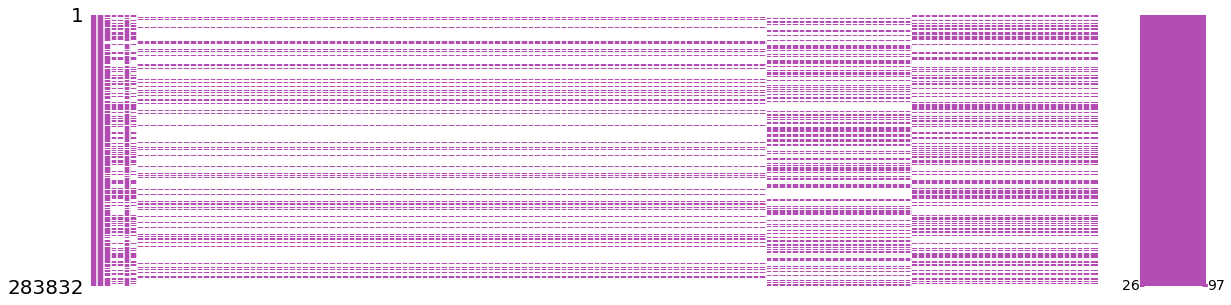

In [203]:
print('Original Data Set - Includes Missing Values');msno.matrix(accidentsdf,fontsize=12,figsize=(20,5),color=(.7,.3,.7));

_In the graph above, white represents missing data, while purple represents real values. Crash ids (in the far left column) appear to include multiple rows for each vehicle/participant/observer, but only one row for each Crash id has data for a majority of the features. This means we can't simply analyze the features as is and have to reduce the data either to the specific participants (2-3 per accident) or to the general accident report (1 per accident)._

<br>_To focus on bicycle accidents, I collect a few random features (unused for this project) and select only rows with a 'Pedalcyclist' count of 1 or more:_

In [5]:
usedcol = ['Crash ID','Crash Hour','Crash Day','Crash Month','Crash Year','Total Pedalcyclist Count',
           'Total Pedalcyclist Fatality Count','Total Pedalcyclist Non-Fatal Injury Count','Crash Type',
           'Collision Type','Median Type','Crash Severity','Intersection Type','Crash ID',
           'Nearest Intersecting Street Number','Road Character']
bikeaccident = accidentsdf[usedcol][accidentsdf['Total Pedalcyclist Count']>0].dropna().reset_index()
print('Training Set: {}\n'.format(len(bikeaccident)))

Training Set: 1473



Cleaned Data Set - No Missing Values


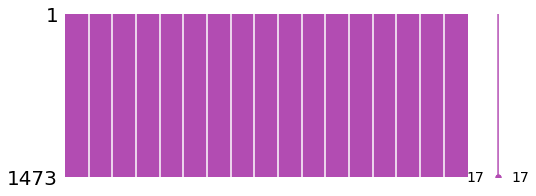

In [217]:
print('Cleaned Data Set - No Missing Values');msno.matrix(bikeaccident,labels=False,figsize=(8,3),color=(.7,.3,.7));

_From this graph, we can see there are a total of 1473 reported ODOT bike related accidents in Multnomah county. The columns are now limited to less than 20 features. This visual looks much better as there is no missing data (represented by white)._

# Data Exploration

_Ok, now I want to explore the features. For example, is there a noticeable difference in time of day for which most accidents occur? My guess would be that most accidents take place when it is dark ~between 7pm-4am._

In [6]:
bikeaccident.index = pd.to_datetime(
    bikeaccident['Crash Year']*10000+bikeaccident['Crash Month']*100+bikeaccident['Crash Day'],format='%Y%m%d')

Total # of Bike Accidents in a Single Week


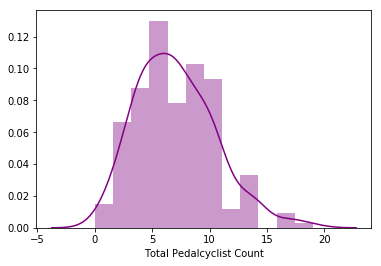

In [245]:
# creating basic time series
ba = bikeaccident['Total Pedalcyclist Count'].groupby(pd.Grouper(freq='W')).count()
sns.distplot(ba,color='purple');print('Total # of Bike Accidents in a Single Week')

Bike Accidents (by hour) w/ Outlier


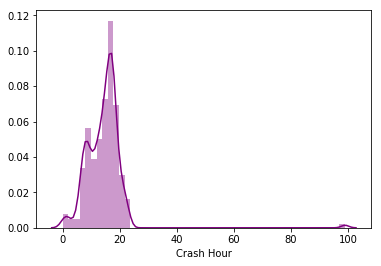

In [244]:
print('Bike Accidents (by hour) w/ Outlier');sns.distplot(bikeaccident['Crash Hour'],color = 'purple');plt.show()

_It seems like there is a random value of 99 that occurs in the data 7 times. This is making the data harder to see, so let's remove it (temporarily). My guess is that 99 represents an unknown hour of the accident as 0 represents midnight._

Bike Accidents (by hour)


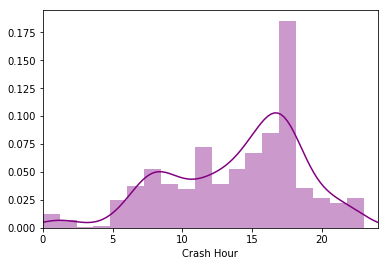

In [246]:
sns.distplot(bikeaccident['Crash Hour'][bikeaccident['Crash Hour']< 99],color='purple');plt.xlim(0,24);print('Bike Accidents (by hour)');plt.show()

_My prediction was wrong. It looks like most accidents happen around evening rush hour (4pm-6pm) with another peak at lunch time, and a third peak during morning rush hour(7am-9am). The data do not appear to be parametric._

<br>_So what about bike deaths? Bike Injuries?_

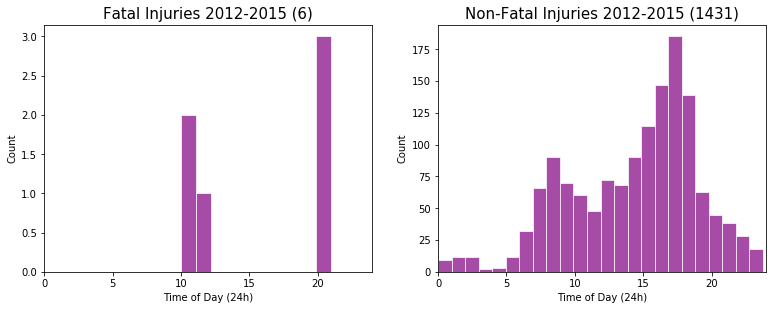

In [219]:
cols = ['Total Pedalcyclist Fatality Count','Total Pedalcyclist Non-Fatal Injury Count']
plt.figure(figsize=(20,10))
plt.subplot(2,3,1)
plt.hist(bikeaccident['Crash Hour'][(bikeaccident[cols[0]]>0)],color='purple',edgecolor='white',alpha=.7)
plt.xlim(0,24);plt.xlabel('Time of Day (24h)');plt.ylabel('Count')
plt.title('Fatal Injuries 2012-2015 ({})'.format(bikeaccident['index'][bikeaccident[cols[0]]>0].count()), size=15)

plt.subplot(2,3,2)
plt.hist(bikeaccident['Crash Hour'][(bikeaccident[cols[1]]>0)],bins=100,color='purple',edgecolor='white',alpha=.7)
plt.xlim(0,24);plt.xlabel('Time of Day (24h)');plt.ylabel('Count')
plt.title('Non-Fatal Injuries 2012-2015 ({})'.format(bikeaccident['index'][bikeaccident[cols[1]]>0].count()),size=15)
plt.show()

_3 bike deaths happened at ~9pm, 2 deaths at ~11am, and 1 death at ~noon.<br> <br>NOTE: There is a notice by ODOT about restricting information regarding fatal accidents. The PDOT reported 6 fatal bike accidents in 2016 so I suspect that this dataset does not accurately reflect severe/fatal bike accidents._

_Bike injuries account for almost all of the bike accident data (1431 out of 1473)._

In [11]:
bikeaccident.drop(['Crash Year','Crash Day','Crash Month','Crash Hour','index'],axis=1).head(3)

,Crash ID,Total Pedalcyclist Count,Total Pedalcyclist Fatality Count,Total Pedalcyclist Non-Fatal Injury Count,Crash Type,Collision Type,Median Type,Crash Severity,Intersection Type,Crash ID,Nearest Intersecting Street Number,Road Character
2012-01-07,1449752,1.0,0.0,1.0,6,6,,4.0,3,1449752,5220,1.0
2012-01-05,1450046,1.0,0.0,1.0,6,3,0,4.0,,1450046,1429,3.0
2012-01-03,1450073,1.0,0.0,1.0,6,3,,4.0,1,1450073,5019,1.0


Bike Accidents: Total vs Injured


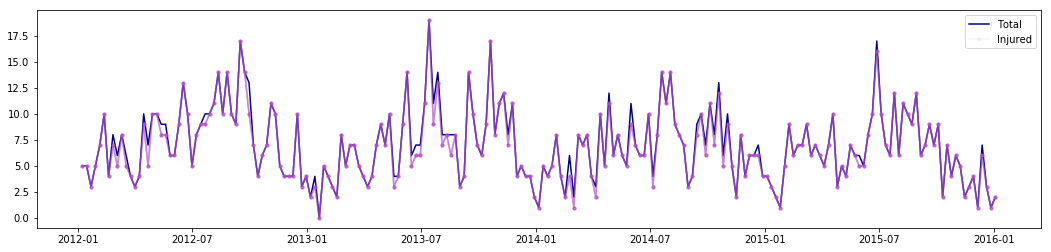

In [221]:
bw = bikeaccident[bikeaccident['Total Pedalcyclist Non-Fatal Injury Count']>0].groupby(pd.Grouper(freq='W'))
plt.figure(figsize=(18,4));plt.plot(ba,color='darkblue');plt.plot(bw.count(),color='mediumorchid',linestyle='-',alpha=.07,marker='.')
plt.legend(['Total','Injured']); print('Bike Accidents: Total vs Injured');plt.show()

_The total number of bike accidents is pretty similar to the number of reported injuries per accident. It's probably safe to assume that accidents without injuries don't get reported as frequently. We can infer that this data is a sample subset of a greater unknown._

Bike Accidents by Year (2012-2015)


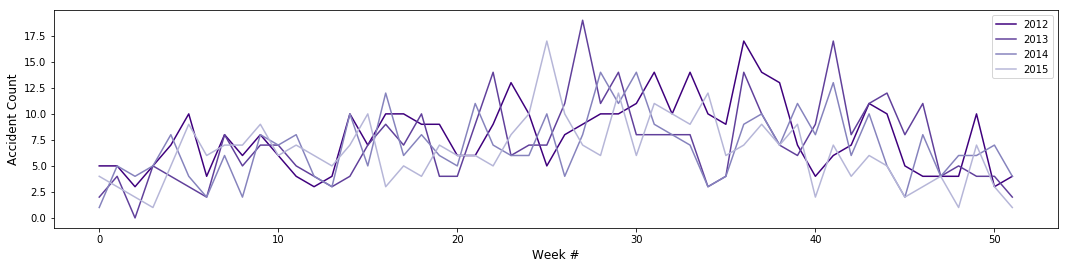

In [223]:
cmap=plt.cm.Purples_r
years = [2012,2013,2014,2015]
yr_plot=[ba.iloc[ba.index.searchsorted(pd.datetime(y, 1, 1)):ba.index.searchsorted(pd.datetime(y, 12, 31))].values for y in years]
plt.figure(figsize=(18,4))
print('Bike Accidents by Year (2012-2015)')
for i,year in enumerate(yr_plot):
    plt.plot(year,color=cmap(i/(len(years)+1)))
plt.legend(years);plt.xlabel('Week #',fontsize=12);plt.ylabel('Accident Count',fontsize=12);plt.show()

_Looking at this graph, there definitely appears to be a similar trend in bike accidents for each year. Summer appears to be the peak time for bike accidents. There could be a number of potential reasons for this: good weather, vacation, and/or new bicyclists._

# Predictions

__Functions__

In [138]:
RMSE = lambda y_predict, y_actual: np.sqrt(np.sum(np.square(np.subtract(y_predict,y_actual)))/len(y_actual))

def visual_validate(y_pred,y,name,printRMSE=True):
    plt.figure(figsize=(6,2))
    print(name)
    if printRMSE:
        print('RMSE: {}'.format(RMSE(y_pred,y)))
    plt.plot(y,color='gray')
    plt.plot(y_pred,color='purple',linestyle='--')

__Test/Train__

In [139]:
# split into train and test sets
lag_split =10
X,y = np.array(range(len(ba.values))),ba.values
train, test = [X[:-lag_split],y[:-lag_split]],[X[-lag_split:],y[-lag_split:]]
train_X, train_y = train[0],train[1]
test_X, test_y = test[0],test[1]
N = len(y)
e = np.random.random_sample(N)-.5

### [OLS] Ordinary Least Squares Regression

_Now I want to build my baseline estimator (a straight line). I'll use RMSE as my metric for evaluation of my predictions._

__Formulas__

Line: $ y = a + bx $<br>
Standard Deviation: $ \sigma=\sqrt {\sum{\frac{(x-\bar{x})^2}n}} $ <br>
Pearson's Correllation Coefficient: $ r= \frac{\sum{(x_i - \bar{x})(y_i - \bar{y})}}{\sqrt{\sum{(x-\bar{x})^2}\sum{(y-\bar{y})^2}}} $<br>
Regression Slope: $ b=r\frac{\sigma_x}{\sigma_y} $ <br>
Root Mean Squared Error: $ \sqrt{\frac{\sum_{i=1}^n {(\hat{y}_{i}- y_{i})}^2}{N}} $

__Functions__

In [140]:
mean = lambda val: val.sum()/len(val)
dif = lambda val: val-mean(val)
r_value = lambda valx,valy:((dif(valx)*dif(valy)).sum())/((((dif(valx)**2).sum())*((dif(valy)**2).sum()))**.5)
std = lambda val:(mean((val-mean(val))**2))**.5
slope = lambda valx,valy: r_value(valx,valy)*std(valy)/std(valx)
intercept = lambda valx,valy: mean(valy) - (slope(valx,valy)*mean(valx))

__Calculations__

In [141]:
x_mean,y_mean = mean(X),mean(y)
x_std,y_std = std(X),std(y)
r = r_value(X,y)
b = slope(X,y)
a = intercept(X,y)
print('Slope: {}\nIntercept: {}\nBaseline RMSE: {}'.format(b,a,RMSE(a+b*X,y)))

Slope: -0.006970660918029338
Intercept: 7.772795625427204
Baseline RMSE: 3.4101986894732423


_The RMSE value feels pretty high. Considering the data appears have a repeating pattern. I feel confident that I can get a lower RMSE value._

In [142]:
print('Statsmodels: Slope={} Intercept={}'.format(linregress(X,y).slope,linregress(X,y).intercept))
print('Numpy: Slope={} Intercept={}'.format(polyfit(X, y, 1)[1],polyfit(X, y, 1)[0]))

Statsmodels: Slope=-0.006970660918029339 Intercept=7.772795625427204
Numpy: Slope=-0.006970660918029325 Intercept=7.772795625427202


_My calculations are the same as Statsmodels and Numpy's internal math! This is a good sign_

__Graph__

Linear Regression Plot - Full Time Series


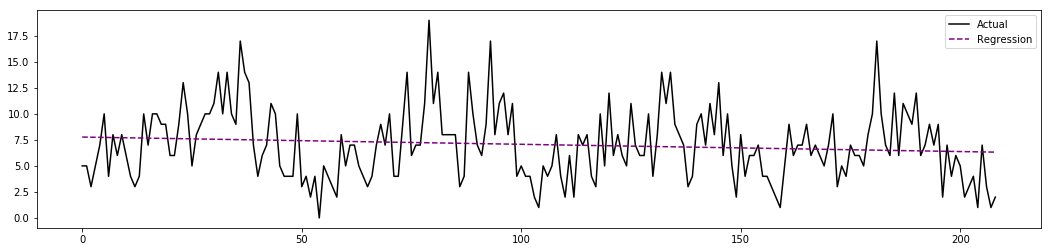

In [144]:
plt.figure(figsize=(18,4));plt.plot(X,y,color='black');plt.plot(X,a+b*X,color = 'purple',linestyle='--')
plt.legend(['Actual','Regression']);print('Linear Regression Plot - Full Time Series');plt.show()

_The linear regression line appears to follow a downward trend in bike accidents from 2012-2015_

__Baseline__

Linear Regression [Baseline]
RMSE: 3.5402310549580256


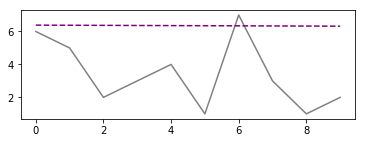

In [145]:
visual_validate(a+b*X[test_X],y[test_X],'Linear Regression [Baseline]')

### [ACF/PACF] Auto and Partial Auto Correlation Functions

__Formulas__

Normalize: $$ z_i=\frac{x_i-\min(x)}{\max(x)-\min(x)}$$
Covariance (sample): $$ \frac{\sum {(x-x_\mu)}\cdot \sum{(y-y_\mu)}}{n-1} $$
Variance (sample): $$ \sigma^2 = \frac{\sum{(x-x_\mu)^2}}{n-1} $$
ACF (1 variable): $$ r_{k} = \frac{\sum_{i=1}^{n-k}(y_{i} - \bar{y})(y_{i+k} - \bar{y})} {\sum_{i=1}^{n}(Y_{i} - \bar{y})^{2} } $$
PACF: $$ \frac{cov(y,x_3|x_1,x_2)}{\sqrt{var(y|x_1,x_2)\cdot var(x_3|x_1,x_2)}} $$

[Formula Links](https://stats.stackexchange.com/questions/129052/acf-and-pacf-formula)

__Functions__

In [146]:
norm = lambda val: (val-val.min())/(val.max()-val.min())
variance = lambda val: np.sum(((val-val.mean())**2)/(len(val)-1))
dev = lambda val: variance(val)**.5

__Calculations__

In [147]:
get_acf = acf(y,unbiased=True,nlags=len(y)-1)
get_pacf = pacf(y,nlags=15, method='ols')

In [148]:
values = pd.DataFrame(ba.values)
values[0] = pd.to_numeric(values[0],errors='coerce')
lag_values = pd.concat([values.shift(-3),values.shift(-2),values.shift(-1),values], axis=1).dropna()
lag_values.columns = ['t', 1,2,3]
lag_values.corr()

,t,1,2,3
t,1.000000,0.434542,0.348564,0.220210
1,0.434542,1.000000,0.429032,0.345030
2,0.348564,0.429032,1.000000,0.424448
3,0.220210,0.345030,0.424448,1.000000


__Gradient Descent__

In [160]:
x_merged = lag_values.drop(['t',3],axis=1).values
y_actual = lag_values['t'].values
theta = np.random.randn(2,1)

In [161]:
sgd = SGDRegressor(max_iter=1000)
sgd.fit(x_merged,y_actual)
sgd_intercept = sgd.intercept_
sgd_coefs = sgd.coef_

__Graph__

[Reference for Lag Plots](https://www.statisticshowto.datasciencecentral.com/lag-plot/)

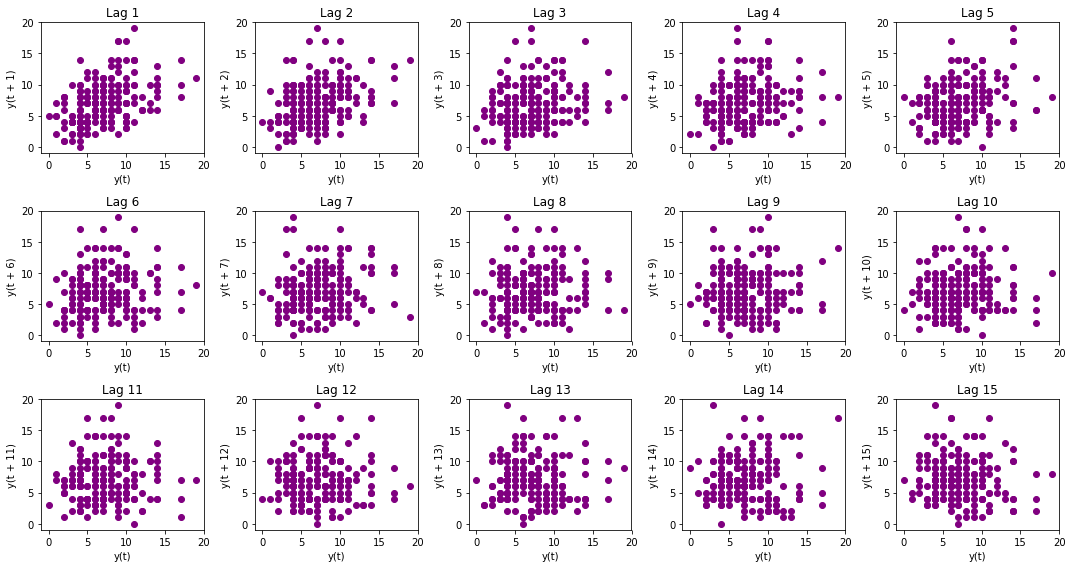

In [153]:
fig = plt.figure(figsize=(15,8))
for num in range(1,16):
    ax = fig.add_subplot(3,5,num)
    pd.plotting.lag_plot(ba,lag=num,c='purple')
    ax.set_title('Lag {}'.format(num))
plt.tight_layout()
plt.show()

Lags one and two appear to be borderline linear (but with a small r-correlation value). Others appear more likely to be elliptical in nature which suggests a sinusoidal distribution.

_Lag Plot - Looks somewhat elliptical?_

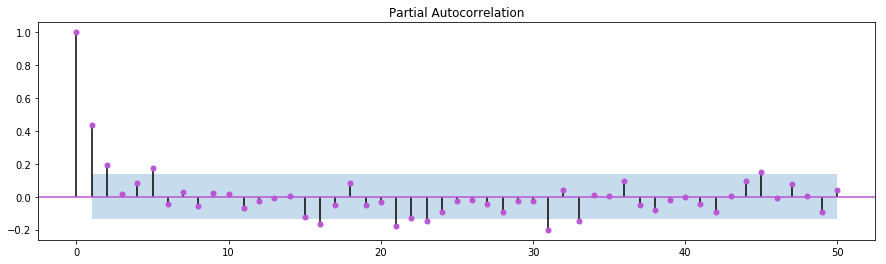

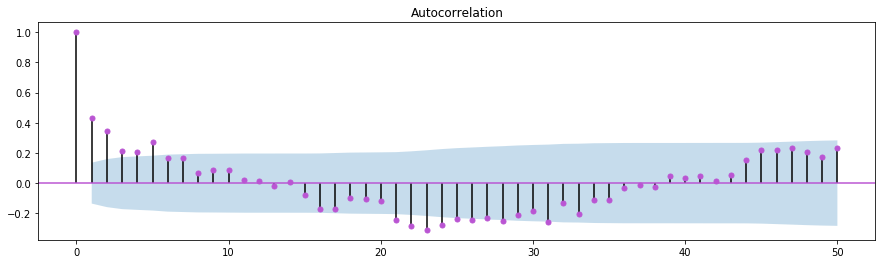

In [156]:
fig, ax = plt.subplots(figsize=(15, 4));plot_pacf(y,color='mediumorchid',lags=50,ax=ax);plt.show()
fig, ax = plt.subplots(figsize=(15, 4));plot_acf(y,color='mediumorchid',lags=50,ax=ax);plt.show()

### [RM] Rolling Mean Model

MA(3)
RMSE: 2.61413369821944


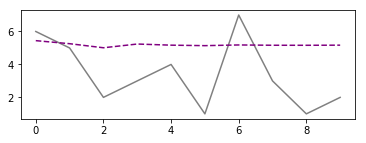

In [157]:
e,y_avg= np.random.random_sample(N)-.5,np.zeros(N)
lags = 1
for i in range(lags, N):
    if i < len(train_y):
        y_avg[i] = (train_y[i]+train_y[i-1]+train_y[i-2])/3
    else:
        y_avg[i] = (y_avg[i-1]+y_avg[i-2]+y_avg[i-3])/3
    prediction = y_avg[test_X]
visual_validate(prediction,test_y,'MA(3)')

### [AR] Auto Regressive Model

__Formulas__

$ \begin{equation*}  y_{t}=\beta_{0}+\beta_{1}y_{t-1}+\beta_{2}y_{t-2}+...+\epsilon_{t}  \end{equation*} $

[Formula Links](https://machinelearningmastery.com/autoregression-models-time-series-forecasting-python/)

__Example AR Model (Shift by 1):__

AR(1) [No Weights!]
RMSE: 2.8635642126552705


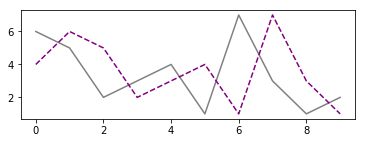

In [158]:
visual_validate(y[np.array(test_X)-1],y[test_X],'AR(1) [No Weights!]')

__AR(1)__

AR(1)
RMSE: 2.5926320533487863


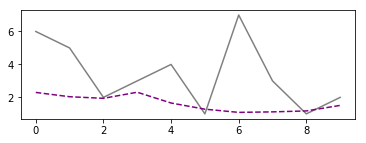

In [159]:
# AR model
y_reg = np.zeros(N)
lags = 1
coefs = pacf(y,nlags=lags, method='ols')
for i in range(lags, N):
    if i < len(train_y):
        y_reg[i] = coefs[0]+ coefs[1]*y[i-1] + e[i]
    else:
        y_reg[i] = coefs[0]+ coefs[1]*y_reg[i-1] + e[i] 
prediction = y_reg[test_X]
visual_validate(prediction,test_y,'AR(1)')

__AR(2)__

AR(2)
RMSE: 3.59799897891962


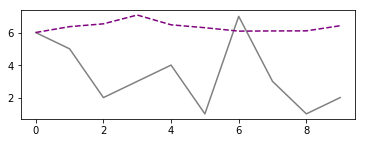

In [227]:
# Using SGD for Weights
y_reg = np.zeros(N)
lags = 2
coefs = sgd_coefs
intercept = sgd_intercept
for i in range(lags, N):
    if i < len(train_y):
        y_reg[i] = intercept+coefs[0]*x_merged[i][0]+coefs[1]*x_merged[i][1] + e[i]
    else:
        y_reg[i] = intercept+coefs[0]*y_reg[i-1]+coefs[1]*y_reg[i-2] + e[i]
prediction = y_reg[test_X]
visual_validate(prediction,test_y,'AR(2)')

AR(2)
RMSE: 2.0054863427702285


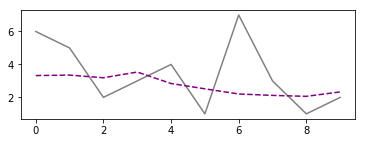

In [172]:
# Using PACF for Weights
y_reg = np.zeros(N)
lags = 2
coefs = pacf(y,nlags=lags, method='ols')
for i in range(lags, N):
    if i < len(train_y):
        y_reg[i] = coefs[0]+ coefs[1]*y[i-1]+coefs[2]*y[i-2] + e[i]
    else:
        y_reg[i] = coefs[0]+coefs[1]*y_reg[i-1]+coefs[2]*y_reg[i-2] + e[i]
prediction = y_reg[test_X]
visual_validate(prediction,test_y,'AR(2)')

__AR Model (14)__

AR(14) - Auto Pick
RMSE: 4.0080769443390745


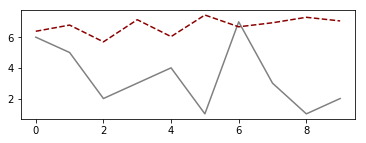

In [50]:
model = AR(train_y)
model_fit = model.fit()
predictions = model_fit.predict(start=len(train_y), end=len(train_y)+len(test_y)-1, dynamic=False)
visual_validate(predictions,test_y,'AR({}) - Auto Pick'.format(model_fit.k_ar))

### [MA] Moving Average Errors

__MA(1)__

MA(1): Residual Errors Plot


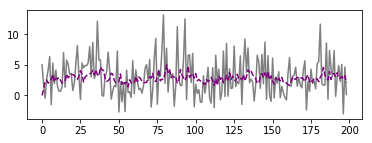

In [173]:
# AR(1) Predictions (Arbitrary prediction method)
y_prediction = np.zeros(N)
lags = 1
coefs = pacf(y,nlags=lags, method='ols')
for i in range(lags, N):
    if i < len(train_y):
        y_prediction[i] = coefs[0]+ coefs[1]*y[i-1] + e[i]
    else:
        y_prediction[i] = coefs[0]+ coefs[1]*y_prediction[i-1] + e[i] 

# MA Residuals
error_actual = y-y_prediction
error_pred = np.zeros(N)
for i in range(lags, N):
    if i < len(train_y):
        error_pred[i] = coefs[0]+coefs[1]*y_prediction[i-1]
visual_validate(error_pred[train_X],error_actual[train_X],'MA({}): Residual Errors Plot'.format(lags),False)

### [ARIMA] Auto Regressive Integrated Moving Average Model

Notes for [ARIMA](https://people.duke.edu/~rnau/411arim.htm) [params](https://stats.stackexchange.com/questions/44992/what-are-the-values-p-d-q-in-arima)

ARIMA(3, 2, 5)
RMSE: 2.619301734378654


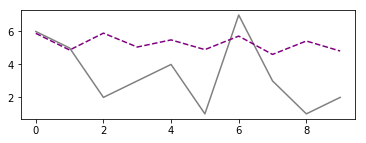

In [252]:
order = (3,2,5)
model = ARIMA(list(train_y), order=order)
model_fit = model.fit()
forecast = model_fit.forecast(steps=len(test_y))
visual_validate(forecast[0],test_y,'ARIMA{}'.format(order))
# print(model_fit.summary())

__Predictions: Dataset 2016__